In [1]:
%run connect_twitter.ipynb

my API Connected !


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

<h3>Gathering Data</h3><br>
Find 200 most recent tweets fom user @realDonaldTrump:

In [3]:
name = '@realDonaldTrump'
nbr_tweets = 200
results = myapi.user_timeline(id=name, count=nbr_tweets)

In [4]:
type(results)

tweepy.models.ResultSet

In [5]:
data=[tweet.text for tweet in results]


Assemble the text into a dataframe

In [6]:
data = pd.DataFrame(data=[tweet.text for tweet in results],
                    columns=['Tweets'])

In [8]:
len(data)

200

The interesting part from here is the quantity of metadata contained in a single tweet. If we want to obtain data such as the creation date, or the source of creation, we can access the info with this attributes. An example is the following:

In [41]:
print(dir(results[0]))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_api', '_json', 'author', 'contributors', 'coordinates', 'created_at', 'destroy', 'entities', 'favorite', 'favorite_count', 'favorited', 'geo', 'id', 'id_str', 'in_reply_to_screen_name', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'parse', 'parse_list', 'place', 'retweet', 'retweet_count', 'retweeted', 'retweets', 'source', 'source_url', 'text', 'truncated', 'user']


Getting the meta data from the first tweet in the lsit

In [9]:
print('id:',results[0].id)
print('created at:',results[0].created_at)
print('source:',results[0].source)
print('likes:',results[0].favorite_count)
print('retweets:',results[0].retweet_count)
print('geo-location:',results[0].geo)
print('message:',results[0].text)

id: 1299165476996743176
created at: 2020-08-28 02:02:41
source: Twitter for iPhone
likes: 0
retweets: 6077
geo-location: None
message: RT @TeamTrump: WATCH: Republican National Convention - Night 4: Land of Greatness #GOP2020 https://t.co/rZXogq3RBg


<h4>Adding more data to the dataframe </h4>

In [10]:
data['len']  = np.array([len(tweet.text) for tweet in results])
data['ID']   = np.array([tweet.id for tweet in results])
data['Date'] = np.array([tweet.created_at for tweet in results])
data['Source'] = np.array([tweet.source for tweet in results])
data['Likes']  = np.array([tweet.favorite_count for tweet in results])
data['RTs']    = np.array([tweet.retweet_count for tweet in results])

In [11]:
data.head()

,Tweets,len,ID,Date,Source,Likes,RTs
0,RT @TeamTrump: WATCH: Republican National Conv...,114,1299165476996743176,2020-08-28 02:02:41,Twitter for iPhone,0,6077
1,https://t.co/PuqeF1ctDs,23,1299165375830073344,2020-08-28 02:02:17,Twitter for iPhone,47645,15088
2,https://t.co/QekykcJKMw,23,1299165334310653952,2020-08-28 02:02:07,Twitter for iPhone,26811,7938
3,https://t.co/vskaY4jx1g,23,1299165301674835968,2020-08-28 02:01:59,Twitter for iPhone,17651,4629
4,https://t.co/FCBc2JjrCs,23,1299165273195524101,2020-08-28 02:01:53,Twitter for iPhone,24324,6803


<h3>Interpretation of the data</h3>

In [12]:
likes_max = np.max(data['Likes'])
retweet_max  = np.max(data['RTs'])

In [13]:
likes = data[data['Likes'] == likes_max].index[0]
retweets  = data[data.RTs == retweet_max].index[0]

In [14]:
retweets

65

In [17]:
# Max FAVs:
print("The tweet with most likes is: \n{}".format(data['Tweets'][likes]))
print("Number of likes: {}".format(likes_max))
print("{} characters.".format(data['len'][likes]))
print("Tweeted at {s}".format(s=data['Date'][likes]))

The tweet with most likes is: 
We will NOT stand for looting, arson, violence, and lawlessness on American streets. My team just got off the phone… https://t.co/cOfgqN5Tor
Number of likes: 290691
140 characters.
Tweeted at 2020-08-26 17:19:36


In [18]:
data.sort_values(by='Likes',ascending=False).head(4)

,Tweets,len,ID,Date,Source,Likes,RTs
65,"We will NOT stand for looting, arson, violence...",140,1298671449968959490,2020-08-26 17:19:36,Twitter for iPhone,290691,60524
158,Joe Biden has said he would lock down the Coun...,140,1298029780437270530,2020-08-24 22:49:50,Twitter for iPhone,240238,47922
119,Very appreciative that @CNN covered the vast m...,140,1298236091313651715,2020-08-25 12:29:38,Twitter for iPhone,228437,35770
67,Just In: Chinese State Media and Leaders of CH...,140,1298637609871212545,2020-08-26 15:05:08,Twitter for iPhone,206746,52129


<h3>Making Graphs</h3>

In [19]:
t_likes = pd.Series(data=data['Likes'].values, index=data['Date'])

In [20]:
t_retweets = pd.Series(data=data['RTs'].values, index=data['Date'])

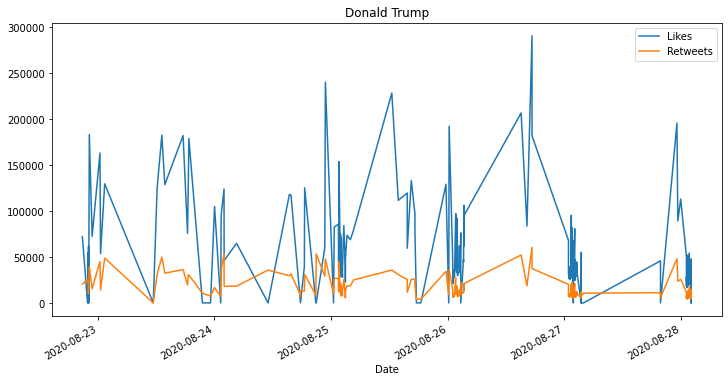

In [21]:
t_likes.plot(title='Donald Trump',
             figsize=(12,6),
             legend=True,
             label='Likes');
t_retweets.plot(legend=True,label='Retweets');

<h3>Sentiment Analysis of the Tweets</h3>

In [22]:
from textblob import TextBlob
import re

Define 2 different utility functions

In [23]:
def clean_tweet(tweet):
    '''
    Utility function to clean the text in a tweet by removing 
    links and special characters using regex.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def analyze_sentiment(tweet):
    '''
    Utility function to classify the polarity of a tweet
    using textblob.
    '''
    #analysis = TextBlob(clean_tweet(tweet))
    analysis = TextBlob(tweet)
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

In [24]:
x  = [ analyze_sentiment(tweet) for tweet in data['Tweets'] ]

In [32]:
data['SA'] = np.array(x)

In [33]:
data.sort_values(by='Date',ascending=False,inplace=True)
data.head()

,Tweets,len,ID,Date,Source,Likes,RTs,SA
0,RT @TeamTrump: WATCH: Republican National Conv...,114,1299165476996743176,2020-08-28,Twitter for iPhone,0,6077,0
11,https://t.co/RAuKRzEW9e,23,1299155621875453952,2020-08-28,Twitter for iPhone,19837,6158,0
19,https://t.co/XVQNptQZoQ,23,1299150878788722690,2020-08-28,Twitter for iPhone,50666,11595,0
18,https://t.co/0HdfZPC7JZ,23,1299150906039173122,2020-08-28,Twitter for iPhone,18647,5027,0
17,https://t.co/bOKlM8PwxB,23,1299150949789900802,2020-08-28,Twitter for iPhone,19261,5417,0


The time has to be removed from the date

In [34]:
data['Date']=data['Date'].apply(lambda x : pd.to_datetime(pd.to_datetime(x).strftime('%Y%m%d')))

In [35]:
df = data.groupby('Date').sum()

In [36]:
df.head()

,len,ID,Likes,RTs,SA
Date,,,,,
2020-08-22,899.0,1.037835e+19,445442.0,167192.0,1.0
2020-08-23,1462.0,1.686778e+19,1345566.0,356156.0,3.0
2020-08-24,2196.0,2.725543e+19,1135135.0,493573.0,5.0
2020-08-25,2898.0,6.620508e+19,2826940.0,761167.0,4.0
2020-08-26,1762.0,5.583372e+19,2622561.0,642075.0,1.0


In [37]:
df['mood']= df['SA'].rolling(window=5).apply(lambda x : np.sum(x))

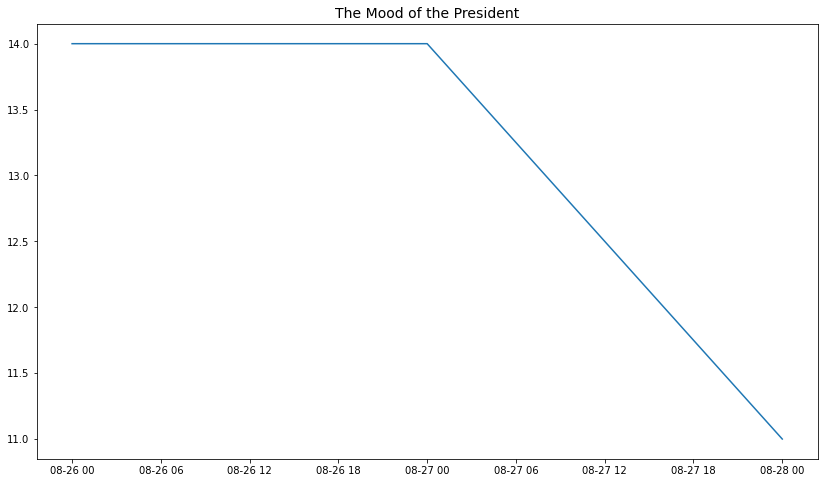

In [38]:
fig = plt.subplots(1,1,figsize=(14,8))
plt.plot(df.index,df['mood'])
plt.title('The Mood of the President',fontsize=14);

In [39]:
pos_tweets = [ tweet for index,tweet in enumerate(data['Tweets']) if data['SA'][index] > 0]
neu_tweets = [ tweet for index, tweet in enumerate(data['Tweets']) if data['SA'][index] == 0]
neg_tweets = [ tweet for index, tweet in enumerate(data['Tweets']) if data['SA'][index] < 0]

In [40]:
print(len(pos_tweets))
print(len(neu_tweets))
print(len(neg_tweets))

30
155
15


<h4>Most Liked positive tweet</h4>

In [43]:
df_positive = data[data['SA']>0].copy()
df_positive.sort_values(by='Likes',ascending=False,inplace=True)
df_positive.head(1).values

array([['Very appreciative that @CNN covered the vast majority of the Republican Convention last night. That was really good… https://t.co/s1MjsyqsZY',
        140, 1298236091313651715, Timestamp('2020-08-25 00:00:00'),
        'Twitter for iPhone', 228437, 35770, 1]], dtype=object)

In [44]:
df_negative = data[data['SA']<0].copy()
df_negative.sort_values(by='Likes',ascending=False,inplace=True)
df_negative.head(1).values

array([['Joe Biden has said he would lock down the Country again. That’s crazy! We’re having record job growth and a booming… https://t.co/OgwWPGfwXy',
        140, 1298029780437270530, Timestamp('2020-08-24 00:00:00'),
        'Twitter for iPhone', 240238, 47922, -1]], dtype=object)

<b> What about the stock market </b>